# Protein Embedding with different models

This notebook demonstrates how to calculate embeddings with different models.

In [1]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
from loguru import logger

from pyeed import Pyeed
from pyeed.embeddings import get_processor

from sklearn.decomposition import PCA

logger.remove()
level = logger.add(sys.stderr, level="ERROR")

2025-05-29 12:01:28.282 | INFO     | pyeed.embeddings.processor:_initialize_devices:44 - Initialized 3 GPU device(s): [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2)]


In [2]:
uri = "bolt://129.69.129.130:7688"
user = "neo4j"
password = "12345678"

eedb = Pyeed(uri, user=user, password=password)
eedb.db.wipe_database(date='2025-05-29')

Pyeed Graph Object Mapping constraints not defined. Use _install_labels() to set up model constraints.
📡 Connected to database.
All data has been wiped from the database.


In [3]:
# these are example ids
df = pd.read_csv("resources/data_example.csv", delimiter=";")
print("The data has the following columns:")
print(df.columns)

# create a dict with protein_id_database as key and phenotype as value
dict_data = dict(zip(df["protein_id_database"], df["phenotype"]))
data_ids = df["protein_id_database"].tolist()

The data has the following columns:
Index(['protein_name', 'phenotype', 'protein_id', 'protein_id_database'], dtype='object')


In [4]:
# now fecth all of the proteins from the database
eedb.fetch_from_primary_db(data_ids, db="ncbi_protein")

In [5]:
query = "MATCH (p:Protein) WHERE p.accession_id IN $protein_ids RETURN p.accession_id, p.sequence"

results = eedb.db.execute_read(query, parameters={"protein_ids": data_ids})
sequences = [result["p.sequence"] for result in results]

data = [(data_ids[i], sequences[i]) for i in range(len(data_ids))]
print(f"First sequence (first 10 AA): {sequences[0][:10]} with length {len(sequences[0])} and id {data_ids[0]}")

First sequence (first 10 AA): MSIQHFRVAL with length 286 and id AAP20891.1


In [6]:
model_names = model_name_list = ["esmc_300m", "facebook/esm2_t33_650M_UR50D", 'prot_t5_xl_uniref50','facebook/esm2_t6_8M_UR50D']

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Embeddings shape: (68, 960)


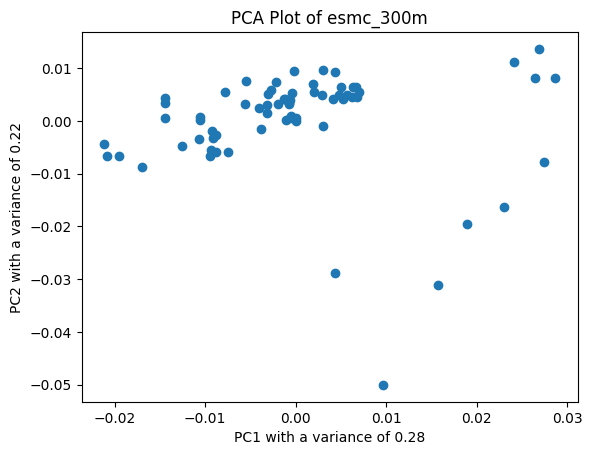

/home/nab/anaconda3/envs/pyeed_niklas_env/lib/python3.10/site-packages/transformers/modeling_utils.py:3437: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/nab/anaconda3/envs/pyeed_niklas_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1899: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Embeddings shape: (68, 1280)


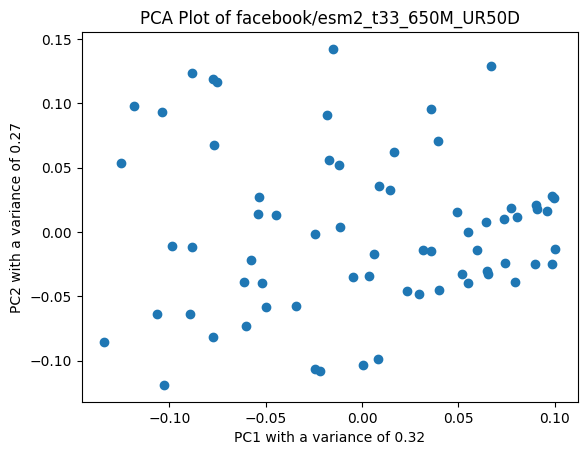

/home/nab/anaconda3/envs/pyeed_niklas_env/lib/python3.10/site-packages/transformers/modeling_utils.py:3437: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/home/nab/anaconda3/envs/pyeed_niklas_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1899: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Passing a tuple of 

Embeddings shape: (68, 1024)


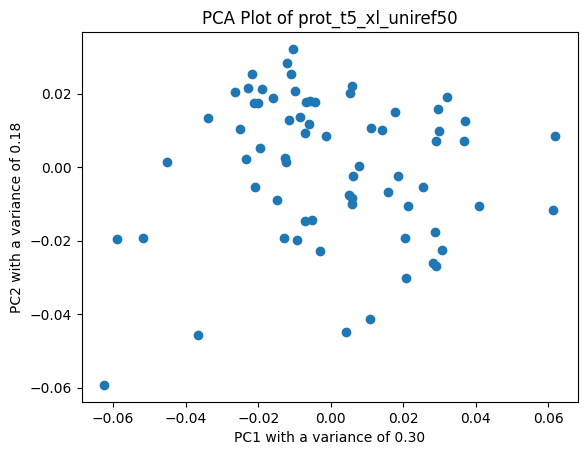

/home/nab/anaconda3/envs/pyeed_niklas_env/lib/python3.10/site-packages/transformers/modeling_utils.py:3437: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/nab/anaconda3/envs/pyeed_niklas_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1899: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Embeddings shape: (68, 320)


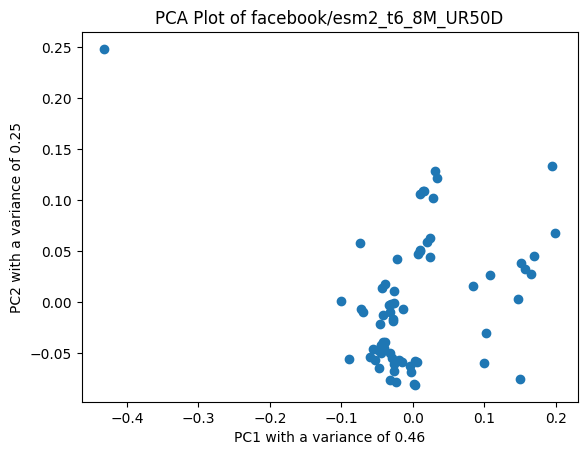

In [7]:
processor = get_processor()

for model_name in model_names:
    embeddings_per_residue = processor.calculate_batch_embeddings(data=data, model_name=model_name, embedding_type="last_hidden_state", num_gpus=1)
    if embeddings_per_residue is None:
        continue

    # convert mean embeddings to numpy array
    embeddings = np.mean(np.array(embeddings_per_residue), axis=1)
    print(f"Embeddings shape: {embeddings.shape}")
    
    # create PCA Plot from embeddings
    pca = PCA(n_components=2)
    pca.fit(embeddings)
    embeddings_pca = pca.transform(embeddings)
    plt.title(f"PCA Plot of {model_name}")
    plt.xlabel(f"PC1 with a variance of {pca.explained_variance_ratio_[0]:.2f}")
    plt.ylabel(f"PC2 with a variance of {pca.explained_variance_ratio_[1]:.2f}")
    plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
    plt.show()